CALCULATING Z-SCORES FOR VIOLIN PLOTS

DETAILED STATISTICAL REPORT

>>> LAYER: L4
----------------------------------------
Animal     | Count (n)  | Median Z   | Mean Z    
----------------------------------------
a2         | 4          | 2.77       | 2.74      
pup1       | 2          | 1.11       | 1.11      
pup2       | 2          | 32.75      | 32.75     
----------------------------------------
Kruskal-Wallis: p = 0.77880 (ns)

>>> LAYER: L2/3
----------------------------------------
Animal     | Count (n)  | Median Z   | Mean Z    
----------------------------------------
a2         | 8          | 2.55       | 4.40      
pup1       | 2          | -0.11      | -0.11     
pup2       | 2          | 0.25       | 0.25      
----------------------------------------
Kruskal-Wallis: p = 0.11406 (ns)

>>> LAYER: L5/6
----------------------------------------
Animal     | Count (n)  | Median Z   | Mean Z    
----------------------------------------
a2         | 17         | 4.97       | 9

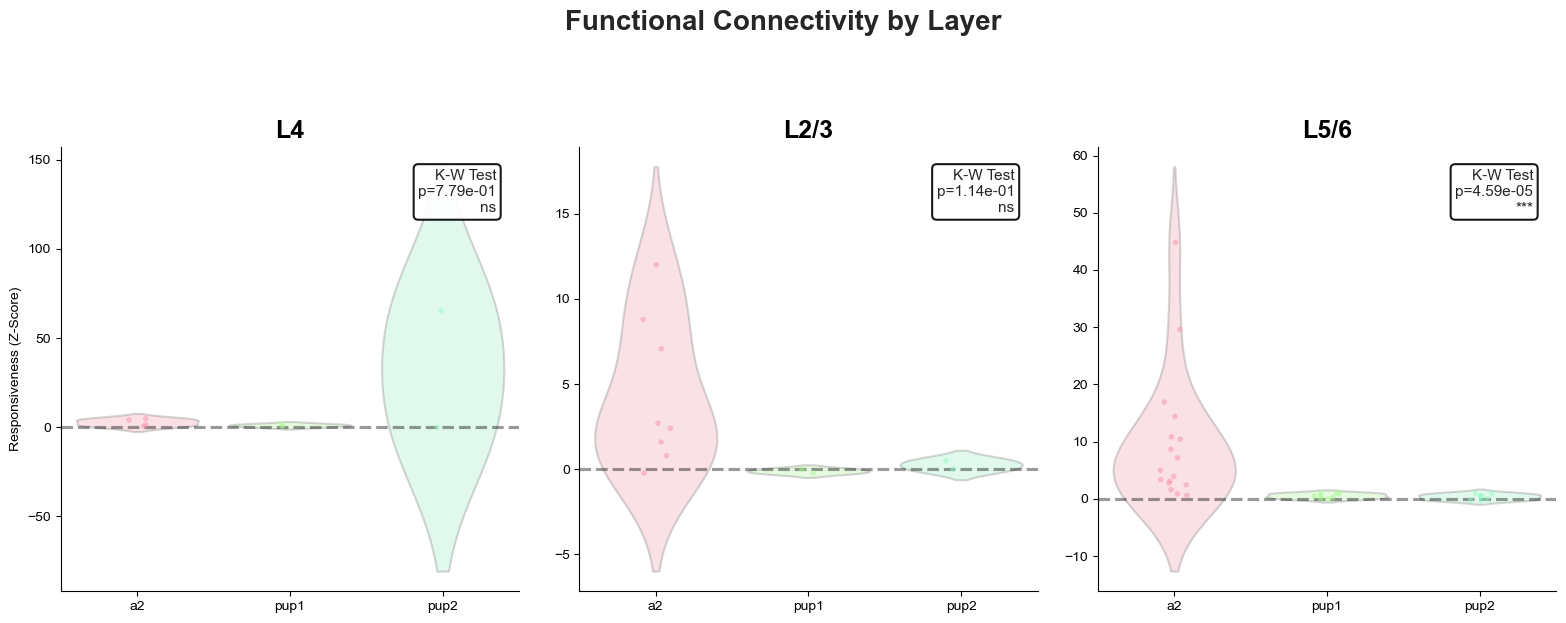


✅ Plot Saved to: results\figures\ZScore_Violin.png


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import stats

# =========================================================
# 1. CONFIGURATION
# =========================================================
TARGETS = [
    ("a2",   "brush_tail"),  
    ("pup1", "brush_tail"),
    ("pup2", "brush_tail") 
]

PRE_WINDOW = 0.5    
POST_WINDOW = 0.5   
EPSILON = 0.5       

CUSTOM_PALETTE = {
    "a2":   "#FA91A8",  
    "pup1": "#A8FA91",  
    "pup2": "#91FAC5"   
}

# =========================================================
# 2. DATA PROCESSING
# =========================================================
z_data = []

csv_path = Path("data/sessions_local.csv") if Path("data/sessions_local.csv").exists() else Path("data/sessions.csv")
meta = pd.read_csv(csv_path)

print(f"{'='*60}")
print(f"CALCULATING Z-SCORES FOR VIOLIN PLOTS")
print(f"{'='*60}")

for session, stim in TARGETS:
    row = meta.loc[(meta['session'] == session) & (meta['stim'] == stim)]
    if len(row) == 0: continue
    row = row.iloc[0]
    
    onsets_path = Path(f"results/summaries/{session}_{stim}_onsets.txt")
    if not onsets_path.exists(): continue
    onsets = np.loadtxt(onsets_path)
    if onsets.ndim == 0: onsets = [onsets]
    
    phy_dir = Path(row['phy_dir'])
    spike_times = np.load(phy_dir / 'spike_times.npy').flatten() / 30000.0
    spike_clusters = np.load(phy_dir / 'spike_clusters.npy').flatten()
    cluster_info = pd.read_csv(phy_dir / 'cluster_info.tsv', sep='\t')
    
    lbl = 'KSLabel' if 'KSLabel' in cluster_info.columns else 'group'
    valid_units = cluster_info[cluster_info[lbl].isin(['good', 'mua'])]
    
    def get_bound(col): return float(row[col]) if col in row and not pd.isna(row[col]) else None
    l1_bot  = get_bound('l1_end')
    l23_bot = get_bound('l23_end')
    l4_bot  = get_bound('l4_end')
    l6_bot  = get_bound('l6_end')
    if l1_bot is None: l1_bot = get_bound('s1_upper_um')

    for _, unit in valid_units.iterrows():
        uid = unit['cluster_id']
        depth = unit['depth']
        
        layer = "Other"
        if l23_bot is not None and l1_bot is not None and l23_bot <= depth <= l1_bot: layer = "L2/3"
        if l4_bot is not None and l23_bot is not None and l4_bot <= depth < l23_bot: layer = "L4"
        if l6_bot is not None and l4_bot is not None and l6_bot <= depth < l4_bot: layer = "L5/6"

        if layer not in ['L2/3', 'L4', 'L5/6']: continue
        
        u_spikes = spike_times[spike_clusters == uid]
        pre_rates = []
        post_rates = []
        for t in onsets:
            c_pre = np.sum((u_spikes >= t - PRE_WINDOW) & (u_spikes < t))
            c_post = np.sum((u_spikes >= t) & (u_spikes < t + POST_WINDOW))
            pre_rates.append(c_pre / PRE_WINDOW)
            post_rates.append(c_post / POST_WINDOW)
            
        mu_pre = np.mean(pre_rates)
        std_pre = np.std(pre_rates)
        mu_post = np.mean(post_rates)
        
        z = (mu_post - mu_pre) / (std_pre + EPSILON)
        z_data.append({'Animal': session, 'Layer': layer, 'Z': z})

# =========================================================
# 3. STATS & PLOTTING (Violin)
# =========================================================
if len(z_data) == 0:
    print("❌ ERROR: No units found.")
else:
    df = pd.DataFrame(z_data)
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharey=False) 
    layers = ['L4', 'L2/3', 'L5/6']
    
    sns.set_style("ticks")
    sns.set_context("talk") 

    print("\n" + "="*60)
    print("DETAILED STATISTICAL REPORT")
    print("="*60)

    for i, layer in enumerate(layers):
        ax = axes[i]
        subset = df[df['Layer'] == layer]
        
        print(f"\n>>> LAYER: {layer}")
        print(f"{'-'*40}")
        print(f"{'Animal':<10} | {'Count (n)':<10} | {'Median Z':<10} | {'Mean Z':<10}")
        print(f"{'-'*40}")

        groups = []
        animals_present = ['a2', 'pup1', 'pup2']
        
        for animal in animals_present:
            data = subset[subset['Animal'] == animal]['Z'].values
            if len(data) > 0:
                groups.append(data)
                print(f"{animal:<10} | {len(data):<10} | {np.median(data):<10.2f} | {np.mean(data):<10.2f}")
            else:
                print(f"{animal:<10} | {0:<10} | {'-':<10} | {'-':<10}")

        # Kruskal-Wallis Test
        p_val = 1.0
        sig_text = "ns"
        if len(groups) >= 2:
            stat, p_val = stats.kruskal(*groups)
            if p_val < 0.001: sig_text = "***"
            elif p_val < 0.01: sig_text = "**"
            elif p_val < 0.05: sig_text = "*"
            print(f"{'-'*40}")
            print(f"Kruskal-Wallis: p = {p_val:.5f} ({sig_text})")
        else:
            print("Not enough groups for stats.")
        
        # PLOT VIOLIN (Fixing the Warning by adding hue=Animal)
        sns.violinplot(data=subset, x="Animal", y="Z", hue="Animal",
                       order=['a2', 'pup1', 'pup2'],
                       palette=CUSTOM_PALETTE,
                       inner=None, density_norm='width', linewidth=1.5, ax=ax, alpha=0.3, legend=False)
        
        # PLOT STRIP
        sns.stripplot(data=subset, x="Animal", y="Z", hue="Animal",
                      order=['a2', 'pup1', 'pup2'],
                      palette=CUSTOM_PALETTE,
                      size=4, alpha=0.5, jitter=True, ax=ax, legend=False)
        
        # Stats Box
        ax.text(0.95, 0.95, f"K-W Test\np={p_val:.2e}\n{sig_text}", 
                transform=ax.transAxes, 
                ha='right', va='top', 
                bbox=dict(boxstyle="round", fc="white", ec="black", alpha=0.9),
                fontsize=11)

        ax.set_title(f"{layer}", fontweight='bold', fontsize=18)
        ax.set_ylabel("Responsiveness (Z-Score)" if i==0 else "")
        ax.set_xlabel("")
        ax.axhline(0, color='black', linestyle='--', alpha=0.4) 
        sns.despine(ax=ax)

    fig.suptitle("Functional Connectivity by Layer", 
                 fontsize=20, fontweight='bold', y=1.05)
    
    plt.tight_layout()
    
    save_path = Path("results/figures/ZScore_Violin.png")
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()
    print(f"\n✅ Plot Saved to: {save_path}")